<a href="https://colab.research.google.com/github/chloepalin/chloepalin.github.io/blob/master/workingAnimalClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls gdrive/MyDrive


In [ ]:
!unzip gdrive/My\ Drive/animal_classifier.zip

In [5]:
from pathlib import Path
import random
import shutil
import os

# Define the test folder path
test_folder = Path('test')  # Replace with your desired path

# Create the test folder
os.makedirs(test_folder, exist_ok=True)

# Specify the number of random images to select from each class
num_images_per_class = 40

# Iterate over the class folders in the animal_classifier folder
for class_folder in Path('animal_classifier').iterdir():
    if class_folder.is_dir():
        images = list(class_folder.glob('*.jpg'))
        # Select random images from the class folder
        selected_images = random.sample(images, min(num_images_per_class, len(images)))

        # Copy the selected images to the test folder while preserving the directory structure
        for image in selected_images:
            destination_folder = test_folder / class_folder.name
            os.makedirs(destination_folder, exist_ok=True)
            shutil.copy(image, destination_folder)

            # Remove the image from the original animal_classifier folder
            os.remove(image)

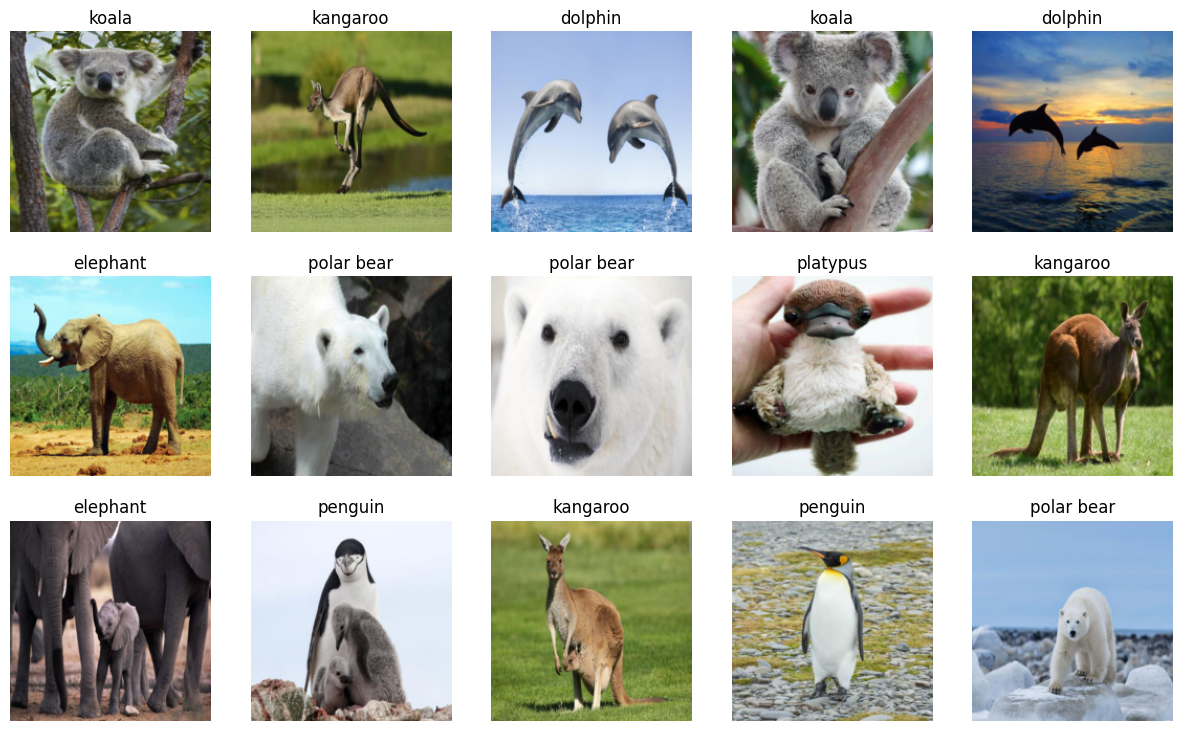

In [6]:
#from pathlib import Path
from fastai.vision.all import *
path = Path('animal_classifier')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=15)


In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.768497,0.716826,0.255814,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.524508,0.215338,0.069767,00:02
1,0.334137,0.063207,0.011628,00:02
2,0.223536,0.053159,0.011628,00:02
3,0.165248,0.057721,0.023256,00:02


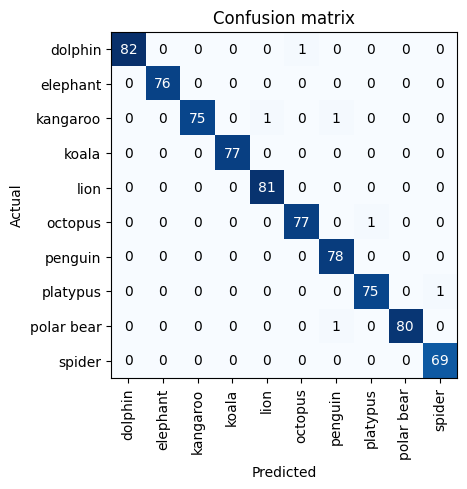

In [10]:
# Test dataset
files = get_files('test')

dl = learn.dls.test_dl(files, with_labels=True)

interp = ClassificationInterpretation.from_learner(learn, dl=dl)
interp.plot_confusion_matrix()

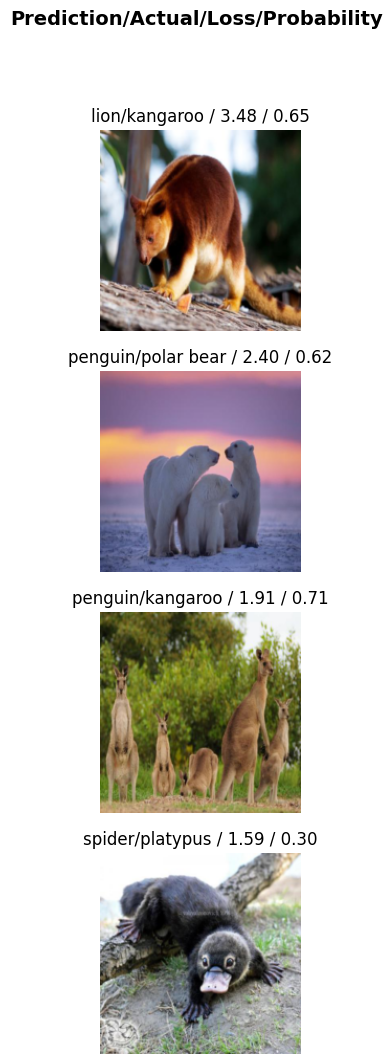

In [13]:
interp = ClassificationInterpretation.from_learner(learn, dl=dl)
interp.plot_top_losses(4, nrows=4)

In [14]:
_, acc = learn.validate(dl=dl)
print("Accuracy:", acc)

Accuracy: 0.007731958758085966


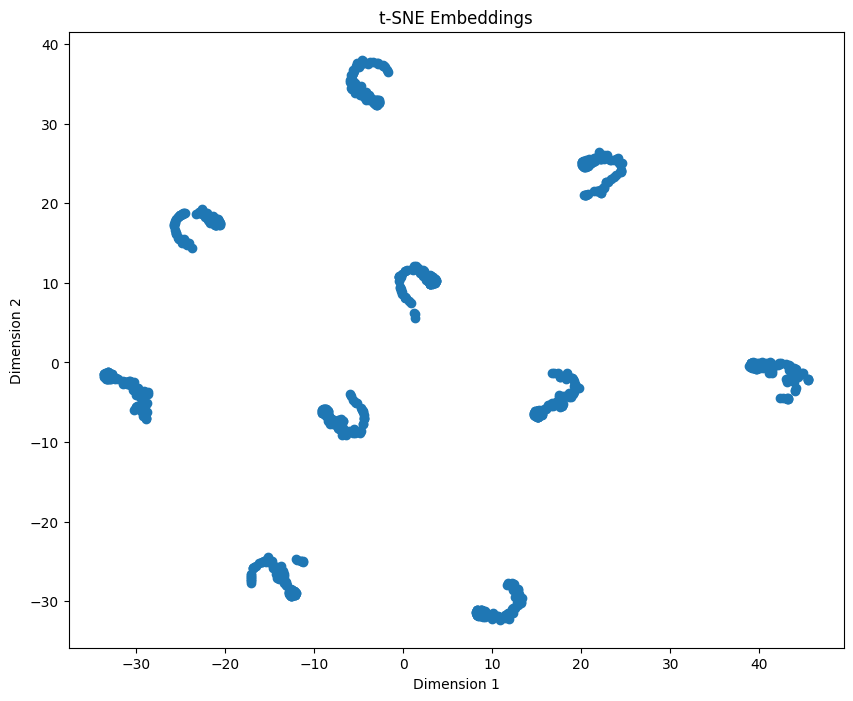

In [17]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get predictions using get_preds()
preds, _ = learn.get_preds(dl=dl)

# Apply t-SNE on the predictions
tsne = TSNE(perplexity=35)
embeddings = tsne.fit_transform(preds.numpy())

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("t-SNE Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()